In [ ]:
# install gymnasium package if missing (uncomment line below and run this cell)
# ! pip install gymnasium[classic-control]

# Tabular Reinforcement Learning

### Agents

In this tutorial we will learn how implement agents that keep track of the value of their actions and the state they are in. We will use three different agents:

- Random agent
- SARSA agent
- Q-learning agent

All agents observe the state, decide which action they should take, and update their internal parameters based on the experience. In general, these agents follow a structure similar to this:

```python
class Agent:
    def __init__(self, action_space, state_space):
        self.action_space = action_space
        self.state_space = state_space

    def act(self, state):
        # the agent's policy: return an action given the state
        pass

    def update(self, state, action, reward, next_state, next_action=None):
        # update values or policy or whichever other parameters they need to
        pass
```

### Environment

The environment, on the other hand, follows this structure:

```python
class Environment:
    def step(self, action) -> tuple:
        # takes in the action
        # returns a tuple of (next_state, reward, done, info)
        pass

    def reset(self) -> tuple:
        # called to reset the episode
        # returns a tuple of (state, info)
        pass
```


## 1. Gridworld

We will train our agents to navigate a gridworld. The gridworld is a 2D grid of size 5x5. The agent can move in 4 directions: up, down, left and right. It receives a reward of 50 if it reaches the goal state, a reward of -2 if it hits an obstacle and a reward of -1 otherwise.

The gridworld is implemented with a class that contains the following methods:
- `__init__`: initializes the gridworld with a given size, a list of obstacles and a goal state (check the other input parameters).
- `new_trial`: resets the state of the agent to the start position and the count of steps within the trial to zero.
- `step`: takes an action as input and returns the next state, the reward and a dictionary with a boolean indicating if the trial is finished.
- `render`: prints the gridworld with the current position of the agent.

<Figure size 600x600 with 0 Axes>

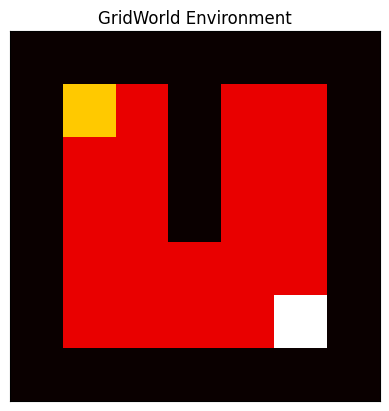

In [1]:
# Part 1: Introduction to Q-learning and SARSA
import matplotlib.pyplot as plt
from environments import GridWorld, plot_reward_per_episode

# Define gridworld parameters
grid_size = 5
starts = [(0,0)]
goal = (grid_size-1, grid_size-1)
obstacles = [(x, grid_size//2) for x in range(grid_size-2)]
max_steps_per_trial = 20

# Create the environment
env = GridWorld(size=grid_size, starts=starts, goal=goal, obstacles=obstacles, max_steps_per_trial=max_steps_per_trial)

# Visualize the environment
plt.figure(figsize=(6,6))
env.render()
plt.title("GridWorld Environment")
plt.show()

<Figure size 300x200 with 0 Axes>

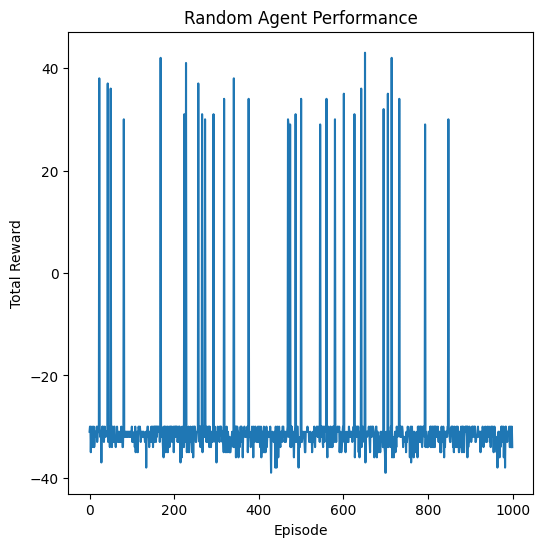

In [3]:
# Define a simple random agent
class RandomAgent:
    def __init__(self, action_space):
        self.action_space = action_space
    
    def get_action(self, state):
        return np.random.choice(self.action_space)
    
    def learn(self, state, action, reward, next_state):
        pass

# Train the random agent
def train_agent(agent, env, num_episodes=100):
    reward_history = []
    for episode in range(num_episodes):
        state = env.starts[0]
        total_reward = 0
        done = False
        while not done:
            action = agent.get_action(state)
            next_state, reward, info = env.step(action)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_reward += reward
            done = info['new_trial']
        reward_history.append(total_reward)
    return reward_history

# Create and train the random agent
random_agent = RandomAgent(list(range(4)))
reward_history = train_agent(random_agent, env, num_episodes=1_000)

# Plot the results
plt.figure(figsize=(6,4))
plot_reward_per_episode(reward_history)
plt.title("Random Agent Performance")
plt.show()

# This concludes Part 1. In Part 2, we'll implement SARSA and Q-learning agents.

In [4]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from agents import SARSAAgent, QLearningAgent

# Training function
def train_agent(agent, env, num_episodes=1000):
    reward_history = []
    for episode in tqdm(range(num_episodes)):
        state = env.starts[0]
        total_reward = 0
        done = False
        
        if isinstance(agent, SARSAAgent):
            action = agent.get_action(state)
        
        while not done:
            if isinstance(agent, QLearningAgent):
                action = agent.get_action(state)
            
            next_state, reward, info = env.step(action)
            total_reward += reward
            
            if isinstance(agent, SARSAAgent):
                next_action = agent.get_action(next_state)
                agent.learn(state, action, reward, next_state, next_action)
                action = next_action
            elif isinstance(agent, QLearningAgent):
                agent.learn(state, action, reward, next_state)
            
            state = next_state
            done = info['new_trial']
        
        reward_history.append(total_reward)
    
    return reward_history

In [5]:
# Train SARSA agent
sarsa_agent = SARSAAgent(action_space=list(range(4)), state_space=(grid_size, grid_size))
sarsa_rewards = train_agent(sarsa_agent, env)

# Train Q-Learning agent
q_learning_agent = QLearningAgent(action_space=list(range(4)), state_space=(grid_size, grid_size))
q_learning_rewards = train_agent(q_learning_agent, env)

100%|██████████| 1000/1000 [00:00<00:00, 8231.68it/s]


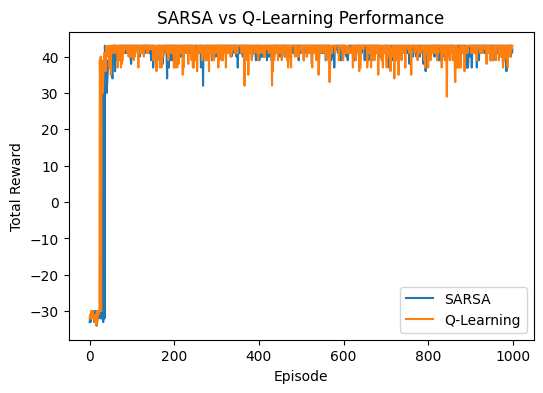

In [7]:
# Plot results
plt.figure(figsize=(6, 4))
plt.plot(sarsa_rewards, label='SARSA')
plt.plot(q_learning_rewards, label='Q-Learning')
plt.title('SARSA vs Q-Learning Performance')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

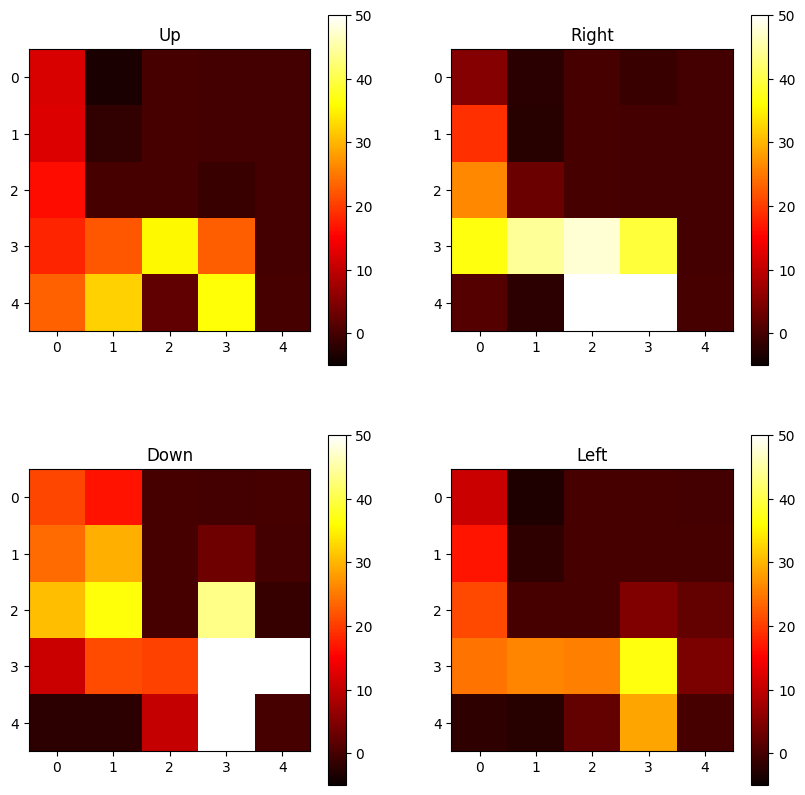

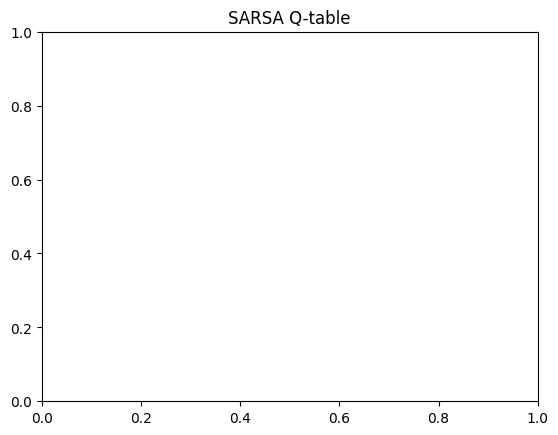

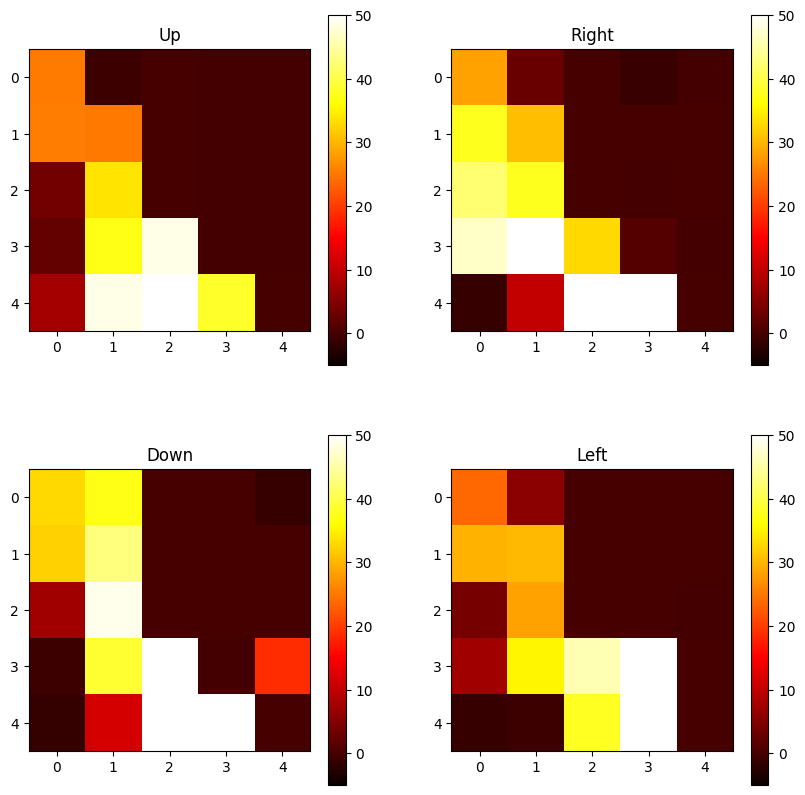

In [9]:
from environments import plot_q_table

# Plot Q-tables
# plt.figure(figsize=(6, 4))
# plt.subplot(1, 2, 1)
plot_q_table(sarsa_agent, list(range(4)))
# plt.title('SARSA Q-table')
# plt.subplot(1, 2, 2)
plot_q_table(q_learning_agent, list(range(4)))
# plt.title('Q-Learning Q-table')
plt.show()

### Part 2: Q-Learning in OpenAI Gym

In this section, we will see the power of Q-Learning in slightly more complex environments. 

#### The Cartpole problem

The [CartPole problem](https://gymnasium.farama.org/environments/classic_control/cart_pole/) consists of a pole attached by an un-actuated joint to a cart, which moves along a frictionless one-dimensional track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

![CartPole](assets/cart_pole.gif)

In [1]:
import gymnasium as gym
import numpy as np

# Create the CartPole environment
env = gym.make("CartPole-v1")

# Define the new observation shape for discretization
new_observation_shape = (20, 20, 20, 20)

# Discretize the continuous state space
bins = []
for i in range(4):
    # For cart position and pole angle, use the environment's limits
    # For cart velocity and pole angular velocity, use -4 to 4 as limits
    low = env.observation_space.low[i] if (i == 0) or (i == 2) else -4
    high = env.observation_space.high[i] if (i == 0) or (i == 2) else 4
    
    # Create bins for each dimension of the state space
    item = np.linspace(low, high, num=new_observation_shape[i], endpoint=False)
    item = np.delete(item, 0)
    bins.append(item)
    print(f"Bins for dimension {i}:\n{np.around(bins[i], 2)}\n")


Bins for dimension 0:
[-4.32 -3.84 -3.36 -2.88 -2.4  -1.92 -1.44 -0.96 -0.48  0.    0.48  0.96
  1.44  1.92  2.4   2.88  3.36  3.84  4.32]

Bins for dimension 1:
[-3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8 -0.4  0.   0.4  0.8  1.2  1.6
  2.   2.4  2.8  3.2  3.6]

Bins for dimension 2:
[-0.38 -0.34 -0.29 -0.25 -0.21 -0.17 -0.13 -0.08 -0.04  0.    0.04  0.08
  0.13  0.17  0.21  0.25  0.29  0.34  0.38]

Bins for dimension 3:
[-3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8 -0.4  0.   0.4  0.8  1.2  1.6
  2.   2.4  2.8  3.2  3.6]



In [2]:
class QLearningAgent:
    def __init__(self, env, new_observation_shape):
        self.env = env
        self.new_observation_shape = new_observation_shape
        self.q_table = np.zeros(new_observation_shape + (env.action_space.n,))
        self.gamma = 0.99
        self.alpha = 0.1
        self.epsilon = 1
        self.epsilon_decay = self.epsilon / 4000
        self.rng = np.random.default_rng()

    def get_discrete_state(self, state):
        """Convert continuous state to discrete state"""
        return tuple(np.digitize(state[i], bins[i]) for i in range(4))

    def act(self, state, epsilon):
        """Choose action using epsilon-greedy policy"""
        if self.rng.random() > epsilon:
            return np.argmax(self.q_table[state])
        else:
            return self.rng.integers(0, self.env.action_space.n)

    def update_q_table(self, state, action, reward, next_state):
        """Update Q-table using Q-learning algorithm"""
        max_future_q = np.max(self.q_table[next_state])
        current_q = self.q_table[state][action]
        new_q = current_q + self.alpha * (reward + self.gamma * max_future_q - current_q)
        self.q_table[state][action] = new_q

    def train(self, episodes):
        reward_records = []
        early_stop_threshold = 195
        early_stop_consecutive = 100
        consecutive_solves = 0

        render_episodes = [0, 100, 1000, episodes - 1]  # Episodes to render

        for episode in range(episodes):
            state, _ = self.env.reset()
            state = self.get_discrete_state(state)
            done = False
            total_reward = 0

            # Use render_env for specific episodes
            if episode in render_episodes:
                try:
                    render_env = gym.make("CartPole-v1", render_mode="human")
                    render_state, _ = render_env.reset()
                    print(f"\nRendering episode {episode}")
                except Exception as e:
                    print(f"Error creating render environment: {e}")
                    render_env = None

            while not done:
                action = self.act(state, self.epsilon)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                
                # Render if it's a render episode
                if episode in render_episodes and render_env is not None:
                    try:
                        render_env.render()
                        render_next_state, _, render_term, render_trunc, _ = render_env.step(action)
                        if render_term or render_trunc:
                            render_env.close()
                            render_env = None
                    except Exception as e:
                        print(f"Error rendering environment: {e}")
                        render_env = None

                done = terminated or truncated
                next_state = self.get_discrete_state(next_state)

                self.update_q_table(state, action, reward, next_state)

                state = next_state
                total_reward += reward

            # Close render_env if it's still open
            if render_env is not None:
                render_env.close()

            # Update epsilon and record rewards
            if self.epsilon - self.epsilon_decay >= 0:
                self.epsilon -= self.epsilon_decay

            reward_records.append(total_reward)
            print(f"Episode {episode} reward: {total_reward}", end="\r")

            # Check for early stopping
            if total_reward >= early_stop_threshold:
                consecutive_solves += 1
                if consecutive_solves >= early_stop_consecutive:
                    print(f"\nEnvironment solved in {episode+1} episodes!")
                    break
            else:
                consecutive_solves = 0

        print("\nTraining completed")
        return reward_records

In [3]:
# Create and train the agent
agent = QLearningAgent(env, new_observation_shape)
reward_history = agent.train(episodes=6_000)


Rendering episode 0
Episode 99 reward: 73.0
Rendering episode 100
Episode 999 reward: 24.00
Rendering episode 1000
Episode 4106 reward: 500.0
Environment solved in 4107 episodes!

Training completed


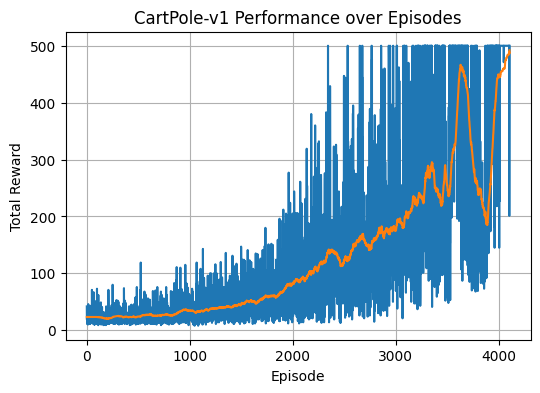

In [4]:
import matplotlib.pyplot as plt

def calculate_moving_average(reward_history, window_size=100):
    cumsum = np.cumsum(np.insert(reward_history, 0, 0))
    moving_avg = (cumsum[window_size:] - cumsum[:-window_size]) / window_size

    # Use the first calculated average for all previous elements
    first_avg = moving_avg[0]
    padded_avg = np.full(window_size - 1, first_avg)

    return np.concatenate([padded_avg, moving_avg])


def plot_performance(reward_history):
    plt.figure(figsize=(6, 4))
    plt.plot(reward_history)
    plt.plot(calculate_moving_average(reward_history))
    plt.title('CartPole-v1 Performance over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.show()

plot_performance(reward_history)

In [22]:
agent.q_table.shape

(20, 20, 20, 20, 2)